In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import kf_internal
from collections import namedtuple
import book_plots as book_plots
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

In [ ]:
INPUT_CSV = 'detected_pos_vid1.csv'

In [53]:
data = pd.read_csv(INPUT_CSV)

# Extract center x and center y coordinates
center_x = data['Center X']
center_y = data['Center Y']

# Fit Gaussian distributions to the data
mean_x, stdev_x = norm.fit(center_x)
mean_y, stdev_y = norm.fit(center_y)

print("Center X - Mean:", mean_x, "Standard Deviation:", stdev_x)
print("Center Y - Mean:", mean_y, "Standard Deviation:", stdev_y)

Center X - Mean: 722.1576519916142 Standard Deviation: 185.73526246910114
Center Y - Mean: 487.8809224318658 Standard Deviation: 84.69439000866277


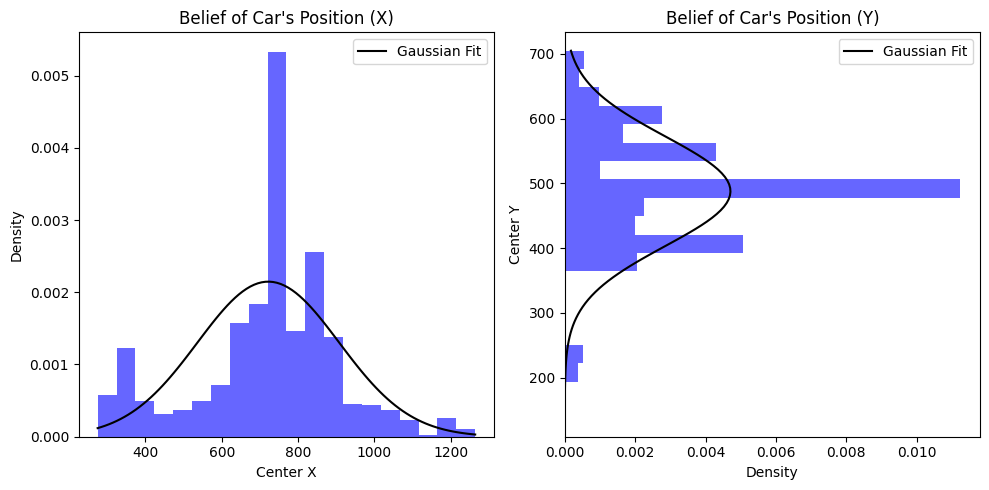

In [57]:
# Load the CSV file containing center x and center y coordinates
data = pd.read_csv(INPUT_CSV)

# Exclude the first row
data = data.iloc[3:]

# Extract center x and center y coordinates
center_x = data['Center X']
center_y = data['Center Y']

# Fit Gaussian distributions to the data
mu_x, std_x = norm.fit(center_x)
mu_y, std_y = norm.fit(center_y)

# Plot center x
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(center_x, bins=20, density=True, alpha=0.6, color='blue')
x_range = np.linspace(min(center_x), max(center_x), 100)
plt.plot(x_range, norm.pdf(x_range, mu_x, std_x), label='Gaussian Fit', color='black')
plt.xlabel('Center X')
plt.ylabel('Density')
plt.title('Belief of Car\'s Position (X)')
plt.legend()

# Plot center y
plt.subplot(1, 2, 2)
plt.hist(center_y, bins=20, density=True, alpha=0.6, color='blue', orientation='horizontal')
y_range = np.linspace(min(center_y), max(center_y), 100)
plt.plot(norm.pdf(y_range, mu_y, std_y), y_range, label='Gaussian Fit', color='black')
plt.xlabel('Density')
plt.ylabel('Center Y')
plt.title('Belief of Car\'s Position (Y)')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
print("Center X - Mean:", mu_x, "Standard Deviation:", std_x)
print("Center Y - Mean:", mu_y, "Standard Deviation:", std_y)

Center X - Mean: 722.0411418975651 Standard Deviation: 185.8231510858336
Center Y - Mean: 487.9147774979009 Standard Deviation: 84.74233108872447


In [59]:
print(center_x.tolist())

[814, 814, 813, 812, 812, 810, 808, 805, 805, 804, 804, 803, 802, 801, 801, 800, 799, 798, 797, 794, 791, 788, 788, 1257, 788, 787, 786, 786, 784, 782, 782, 781, 781, 779, 776, 776, 775, 773, 771, 770, 768, 766, 766, 765, 763, 762, 760, 758, 756, 1264, 754, 1263, 754, 1263, 752, 750, 749, 749, 748, 746, 743, 743, 742, 739, 737, 1217, 736, 1212, 736, 1212, 735, 1209, 735, 1209, 734, 1204, 734, 1204, 731, 1201, 731, 1201, 730, 1194, 1195, 730, 1194, 1195, 730, 728, 1186, 724, 721, 720, 718, 715, 713, 713, 711, 707, 707, 702, 700, 699, 692, 690, 690, 685, 687, 682, 681, 678, 670, 667, 666, 662, 659, 658, 654, 653, 651, 648, 645, 643, 642, 640, 635, 632, 632, 631, 635, 642, 647, 655, 660, 663, 668, 671, 675, 677, 679, 680, 682, 683, 682, 683, 683, 681, 681, 680, 680, 681, 682, 682, 683, 684, 684, 685, 1050, 685, 1050, 685, 1050, 685, 685, 685, 685, 686, 686, 685, 686, 1050, 687, 1052, 687, 1052, 687, 1052, 687, 1052, 688, 689, 691, 693, 692, 691, 1055, 691, 1057, 691, 1057, 692, 1059, 692,

In [60]:
process_var = stdev_x**2. # variance in the dog's movement
sensor_var = std_x**2. # variance in the sensor

gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

x = gaussian(mean_x, stdev_x)  # car's position, N(mean, stdev)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)
def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

zs = center_x.tolist()

print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {mu_x:10.3f}')

PREDICT			UPDATE
     x      var		  z	    x      var
 723.158  34683.323	814.000	 768.679  17303.307
 769.679  51800.895	814.000	 796.273  20719.031
 797.273  55216.618	813.000	 806.949  21244.679
 807.949  55742.267	812.000	 810.450  21322.040
 811.450  55819.627	812.000	 811.790  21333.349
 812.790  55830.937	810.000	 811.066  21335.001
 812.066  55832.588	808.000	 809.554  21335.242
 810.554  55832.830	805.000	 807.122  21335.277
 808.122  55832.865	805.000	 806.193  21335.282
 807.193  55832.870	804.000	 805.220  21335.283
 806.220  55832.871	804.000	 804.848  21335.283
 805.848  55832.871	803.000	 804.088  21335.283
 805.088  55832.871	802.000	 803.180  21335.283
 804.180  55832.871	801.000	 802.215  21335.283
 803.215  55832.871	801.000	 801.847  21335.283
 802.847  55832.871	800.000	 801.088  21335.283
 802.088  55832.871	799.000	 800.180  21335.283
 801.180  55832.871	798.000	 799.215  21335.283
 800.215  55832.871	797.000	 798.229  21335.283
 799.229  55832.871	794.000	 795.99

In [74]:
# save output in these lists for plotting
xs, predictions = [], []
x = gaussian(mean_x, stdev_x)
process_model = gaussian(velocity, process_var) 

for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)
print(predictions)
def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

[723.1576519916142, 769.6792839161266, 797.2728490572523, 807.9489544315994, 811.4504298219427, 812.7899632630875, 812.0661448930554, 810.553791202636, 808.1222580862732, 807.1931011892086, 806.2201722292091, 805.8483891725026, 805.0884482286103, 804.180181428662, 803.2152352197513, 802.8465026035315, 802.0877273182385, 801.1799059488484, 800.2151299512954, 799.2285900161735, 796.9979887562388, 794.2919972799439, 791.4043460628442, 790.3008947220702, 1079.661372949942, 900.4518717246134, 831.3530958401511, 804.3306714179054, 794.0046561834057, 788.8230556426585, 785.6072781409624, 784.3784406778835, 783.2909955584873, 782.8754527228739, 781.4809175976096, 779.0944100990939, 778.1824596241162, 777.2161057811953, 775.6110905463776, 773.7620251419912, 772.4375737839714, 770.6957195913104, 768.7943642390907, 768.0678038081528, 767.172292624986, 765.5943483284544, 764.3734998391619, 762.6712351660827, 760.7850080634953, 758.8284838321235, 1071.9600014242071, 876.501304522662, 1116.308166164

interactive(children=(IntSlider(value=1, description='step', max=7146, min=1), Output()), _dom_classes=('widge…

[768.6792839161266, 796.2728490572523, 806.9489544315994, 810.4504298219427, 811.7899632630875, 811.0661448930554, 809.553791202636, 807.1222580862732, 806.1931011892086, 805.2201722292091, 804.8483891725026, 804.0884482286103, 803.180181428662, 802.2152352197513, 801.8465026035315, 801.0877273182385, 800.1799059488484, 799.2151299512954, 798.2285900161735, 795.9979887562388, 793.2919972799439, 790.4043460628442, 789.3008947220702, 1078.661372949942, 899.4518717246134, 830.3530958401511, 803.3306714179054, 793.0046561834057, 787.8230556426585, 784.6072781409624, 783.3784406778835, 782.2909955584873, 781.8754527228739, 780.4809175976096, 778.0944100990939, 777.1824596241162, 776.2161057811953, 774.6110905463776, 772.7620251419912, 771.4375737839714, 769.6957195913104, 767.7943642390907, 767.0678038081528, 766.172292624986, 764.5943483284544, 763.3734998391619, 761.6712351660827, 759.7850080634953, 757.8284838321235, 1070.9600014242071, 875.501304522662, 1115.3081661641093, 892.447963992

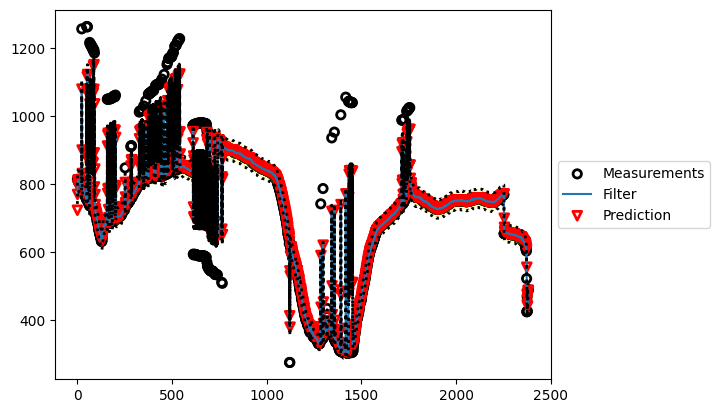

In [82]:
import book_plots as book_plots

# save output in these lists for plotting
xs, predictions = [], []
x = gaussian(mean_x, stdev_x)
process_model = gaussian(velocity, process_var) 

for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

print(xs)
# for i, z in enumerate(zs):
#     prior = predict(x, process_model)
#     likelihood = gaussian(z, sensor_var) 
#     x = update(prior, likelihood)

#     # save results
#     predictions[i] = prior
#     xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs, var=predictions)
book_plots.plot_predictions(predictions)
book_plots.show_legend()
# kf_internal.print_variance(xs)